# Assignment 1 for Genome Science (BBMS3009)
This assignment aims to understand the normalization of RNA-seq count data and the basics of the statistical tests behind Differential Gene expression detection.

**Top note**

You can run this notebook on one of these three options
1. colab cloud computing by using [this link](https://colab.fan/StatBiomed/GenomeScienceCourse/assignments/Assignment1_BBMS3009.ipynb) (suggested)
2. local R studio (use the [Assignment1_BBMS3009.Rmd](./Assignment1_BBMS3009.Rmd) notebook) 
3. local jupyter lab with R environment via conda (multiple steps required).

**Running time**

* `DESeq2` installation: ~10min
* Running the whole notebook: ~5min

**Main reference**:
* [Chapter 8 in Modern Statistics for Modern Biology](https://web.stanford.edu/class/bios221/book/Chap-CountData.html)
* [Chapter 8 in Computational Genomics with R](http://compgenomr.github.io/book/rnaseqanalysis.html)


## Part 0. Environment setting
Installing the DESeq2 package for loading data (only need once)

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

## Part 1. Load data

#### Load count matrix
gene-by-sample, with additional column for gene length

In [1]:
counts_url <- 'https://raw.github.com/compgenomr/compGenomRData/master/inst/extdata/rna-seq/SRP029880.raw_counts.tsv'

counts <- as.matrix(read.csv(counts_url, header = T, sep = '\t'))

In [2]:
dim(counts)
colnames(counts)

[1] 19719    11

[1] "CASE_1" "CASE_2" "CASE_3" "CASE_4" "CASE_5" "CTRL_1" "CTRL_2" "CTRL_3"
 [9] "CTRL_4" "CTRL_5" "width"

In [3]:
summary(counts[,1:3])

     CASE_1              CASE_2              CASE_3         
 Min.   :        0   Min.   :        0   Min.   :        0  
 1st Qu.:     5155   1st Qu.:     6464   1st Qu.:     3972  
 Median :    80023   Median :    85064   Median :    64145  
 Mean   :   295932   Mean   :   273099   Mean   :   263045  
 3rd Qu.:   252164   3rd Qu.:   245484   3rd Qu.:   210788  
 Max.   :205067466   Max.   :105248041   Max.   :222511278  

#### Load colData for sample information

In [4]:
coldata_url <- 'https://raw.github.com/compgenomr/compGenomRData/master/inst/extdata/rna-seq/SRP029880.colData.tsv'

col_data <- read.table(coldata_url, header = T, sep = '\t', stringsAsFactors = TRUE)

In [5]:
col_data

,source_name,group
,<fct>,<fct>
CASE_1,metastasized cancer,CASE
CASE_2,metastasized cancer,CASE
CASE_3,metastasized cancer,CASE
CASE_4,metastasized cancer,CASE
CASE_5,metastasized cancer,CASE
CTRL_1,normal colon,CTRL
CTRL_2,normal colon,CTRL
CTRL_3,normal colon,CTRL
CTRL_4,normal colon,CTRL


## 2. Normalization
For gene length bias correction, is often included in the "normalization" term.

### 2.1 CPM: Count per million
Normalization to the library size

In [6]:
cpm <- t(t(counts[, 1:10]) / colSums(counts[, 1:10])) * 10^6

In [7]:
head(cpm)

,CASE_1,CASE_2,CASE_3,CASE_4,CASE_5,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5
TSPAN6,133.0525426,69.0267115,118.0347011,63.45319990,75.1705899,83.6818109,90.8357832,63.7170750,66.1201154,116.5649088
TNMD,0.2541349,0.1496685,0.5774069,0.04131475,0.1603471,0.6925826,0.3495018,0.8603467,0.5436178,0.7308802
DPM1,62.5344859,50.9433750,47.9546579,51.61492360,47.6835767,31.5816791,22.8556382,21.7976235,18.6670761,36.4577954
SCYL3,17.7536255,18.1282742,18.9680587,16.32642166,14.9280985,24.0552454,19.8292196,20.5182320,17.9989890,18.6607898
C1ORF112,15.5608340,10.9995218,11.8488915,15.14762970,6.5660321,7.8228489,6.3511382,7.3077662,5.1345687,10.6632034
FGR,9.7817077,27.0411643,5.1667799,23.44215745,23.2660030,8.9317887,4.5418541,4.1459346,5.1711610,4.3532958


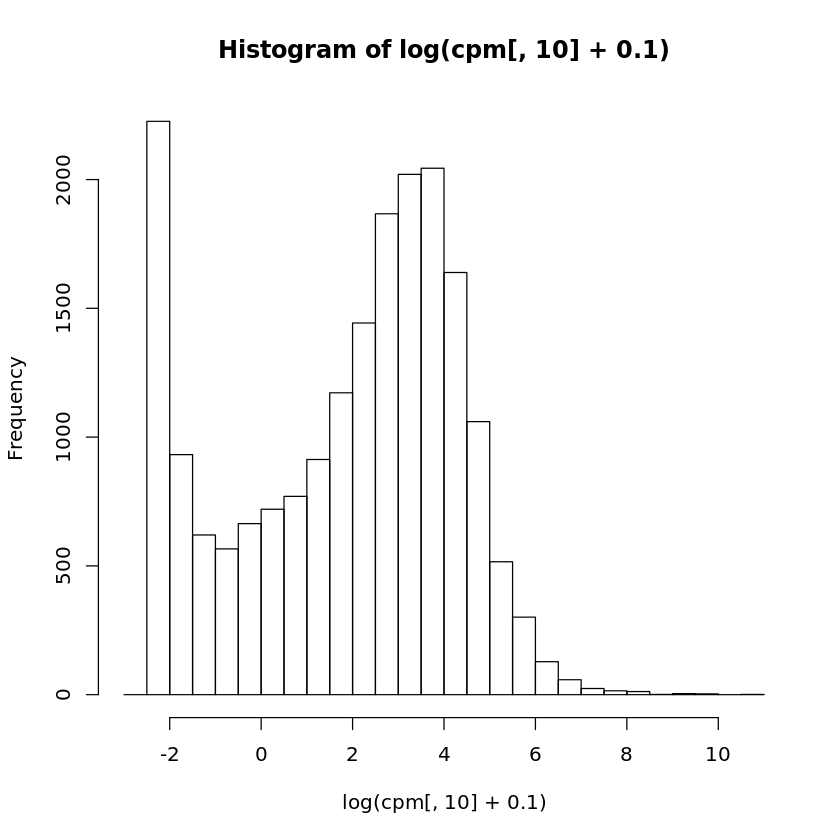

In [8]:
hist(log(cpm[, 10] + 0.1), breaks=seq(-3, 11, 0.5))

### 2.2 RPKM: Read per killobase per million
Correction the gene length bias. It also often contained in the normalization term

In [9]:
geneLengths <- counts[, 11]
head(geneLengths)

TSPAN6     TNMD     DPM1    SCYL3 C1ORF112      FGR 
   12883    15084    23689    44637   192074    23214

In [10]:
rpkm <- cpm / geneLengths * 10^3

In [11]:
head(rpkm)

,CASE_1,CASE_2,CASE_3,CASE_4,CASE_5,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5
TSPAN6,10.32776081,5.357968757,9.16205085,4.925343468,5.83486687,6.49552207,7.05082537,4.94582589,5.13235390,9.04796312
TNMD,0.01684798,0.009922336,0.03827943,0.002738979,0.01063028,0.04591505,0.02317037,0.05703704,0.03603937,0.04845400
DPM1,2.63981113,2.150507621,2.02434285,2.178856161,2.01289952,1.33317907,0.96482073,0.92015803,0.78800608,1.53901792
SCYL3,0.39773339,0.406126625,0.42494027,0.365759833,0.33443328,0.53890820,0.44423280,0.45966871,0.40323026,0.41805654
C1ORF112,0.08101479,0.057267105,0.06168920,0.078863509,0.03418491,0.04072831,0.03306610,0.03804662,0.02673224,0.05551612
FGR,0.42137106,1.164864492,0.22257172,1.009828442,1.00224016,0.38475871,0.19565151,0.17859631,0.22276045,0.18752890


In [12]:
# smoothScatter(log10(geneLengths + 0.1), log10(cpm[, 10] + 0.1))

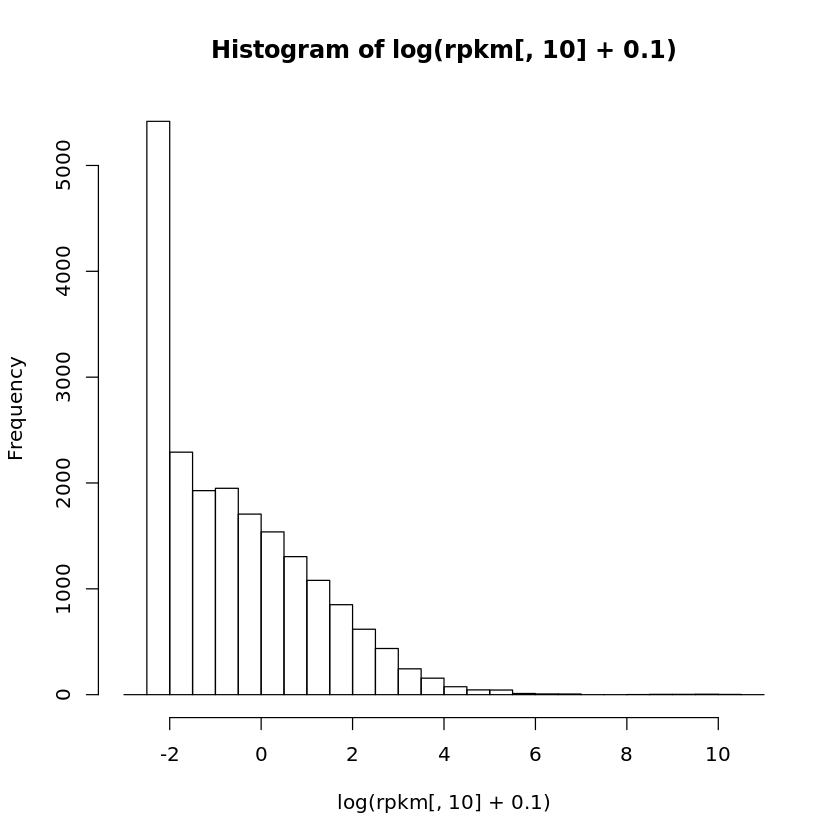

In [13]:
hist(log(rpkm[, 10] + 0.1), breaks=seq(-3, 11, 0.5))

### 2.3 TPM: transcript per million


In [14]:
tpm <- t(t(rpkm) / colSums(rpkm)) * 10^6

In [15]:
head(tpm)

,CASE_1,CASE_2,CASE_3,CASE_4,CASE_5,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5
TSPAN6,65.2454175,34.94535342,56.6343869,28.46238940,33.77412727,30.9262602,23.36534574,20.4865448,17.59616734,35.9038047
TNMD,0.1064367,0.06471474,0.2366208,0.01582791,0.06153155,0.2186092,0.07678302,0.2362582,0.12356021,0.1922734
DPM1,16.6769528,14.02588411,12.5132919,12.59109195,11.65132402,6.3474872,3.19726681,3.8114683,2.70166227,6.1070760
SCYL3,2.5126726,2.64880948,2.6267297,2.11363915,1.93580977,2.5658315,1.47211886,1.9040346,1.38246645,1.6589171
C1ORF112,0.5118093,0.37350334,0.3813262,0.45573348,0.19787349,0.1939142,0.10957595,0.1575963,0.09165093,0.2202971
FGR,2.6620030,7.59739431,1.3758069,5.83555858,5.80129545,1.8319002,0.64835886,0.7397796,0.76372950,0.7441455


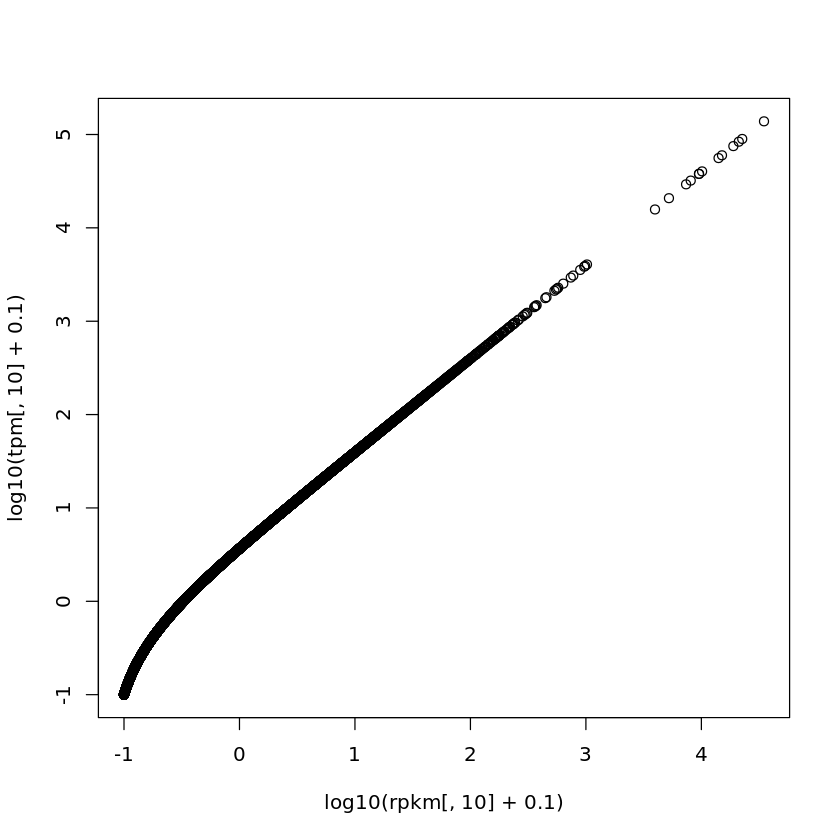

In [16]:
plot(log10(rpkm[, 10] + 0.1), log10(tpm[, 10] + 0.1))

<font color='red'>**Q1: Define CPM, TPM and RPKM, and describe their difference?**</font>

## 3. Differential gene expression

In [17]:
library(DESeq2)
library(stats)
library(ggplot2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: 'S4Vectors'


The

In [18]:
#define the design formula
designFormula <- "~ group"

#create a DESeq dataset object from the count matrix and the colData 
dds <- DESeqDataSetFromMatrix(countData = counts[, 1:10], 
                              colData = col_data, 
                              design = as.formula(designFormula))
                              
#print dds object to see the contents
print(dds)

converting counts to integer mode



class: DESeqDataSet 
dim: 19719 10 
metadata(1): version
assays(1): counts
rownames(19719): TSPAN6 TNMD ... MYOCOS HSFX3
rowData names(0):
colnames(10): CASE_1 CASE_2 ... CTRL_4 CTRL_5
colData names(2): source_name group


`geom_smooth()` using formula 'y ~ x'



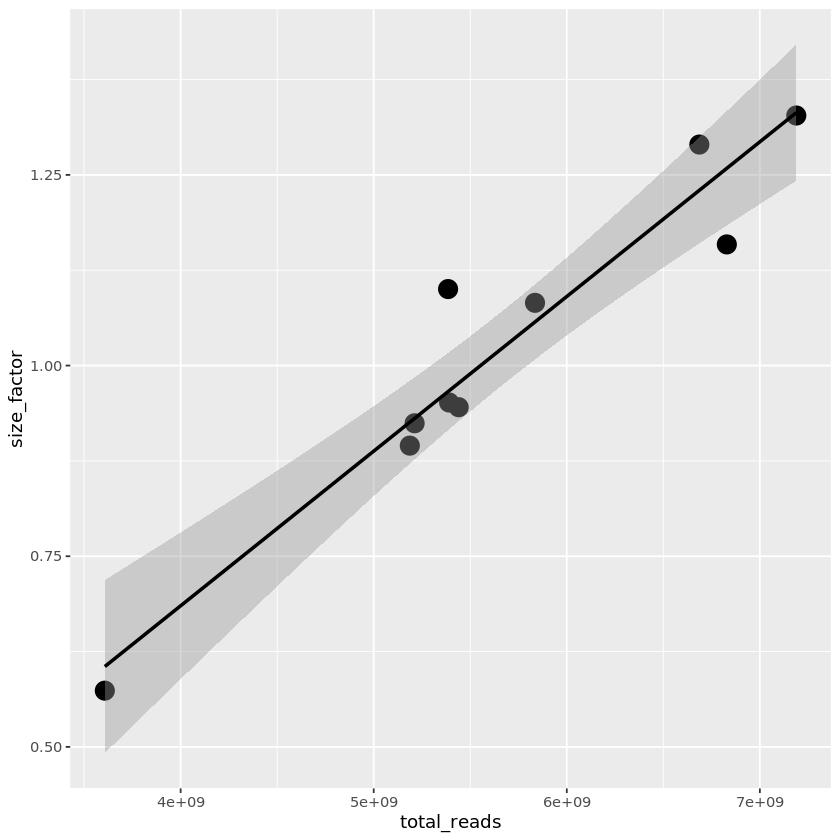

In [19]:
size_factor <- DESeq2::estimateSizeFactorsForMatrix(dds@assays@data$counts)
total_reads <- colSums(dds@assays@data$counts)

# plot(total_reads, size_factor)
df <- data.frame(size_factor=size_factor, total_reads=total_reads)

ggplot(df, aes(x=total_reads, y=size_factor)) + 
  geom_point(size=5)+
  geom_smooth(method=lm, color="black")

<font color='red'>**Q2: What is the relationship between the learned size factor and total reads?**</font>

Hints: see the [Fig. 8.1](https://web.stanford.edu/class/bios221/book/Chap-CountData.html#fig:rnaseq-normalization) in the book 
[Modern Statistics for Modern Biology](https://web.stanford.edu/class/bios221/book/Chap-CountData.html).

#### Remove lowly expressed genes
This step can reduce the number of tests, but be careful as some informative genes may indeed have low expression

Here, we only remove genes with no expression at all

In [20]:
#For each gene, we count the total number of reads for that gene in all samples 
#and remove those that don't have at least 1 read. 

dds <- dds[ rowSums(dds@assays@data$counts) > 1, ]
dim(dds)

[1] 19097    10

In [21]:
sum(rowSums(dds@assays@data$counts) > 1)

[1] 19097

### 3.1 Perform DE analysis

In [22]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [23]:
#compute the contrast for the 'group' variable where 'CTRL' 
#samples are used as the control group. 

DEresults = results(dds, contrast = c("group", 'CASE', 'CTRL'))

#sort results by increasing p-value
DEresults <- as.data.frame(DEresults[order(DEresults$pvalue), ])

In [24]:
#shows the top results
head(DEresults)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CYP2E1,4829888.9,9.360244,0.2152217,43.49116,0.000000e+00,0.000000e+00
FCGBP,10349993.2,-7.575787,0.1864329,-40.63545,0.000000e+00,0.000000e+00
ASGR2,426421.7,8.018301,0.2162068,37.08626,4.678977e-301,2.877415e-297
GCKR,100182.7,7.828413,0.2333762,33.54417,1.094790e-246,5.049446e-243
APOA5,438054.0,10.202485,0.3125005,32.64790,8.582274e-234,3.166688e-230
APCS,899875.4,9.649894,0.3033213,31.81410,4.131410e-222,1.270340e-218


#### Visualize the DE results
plotting the MA plot

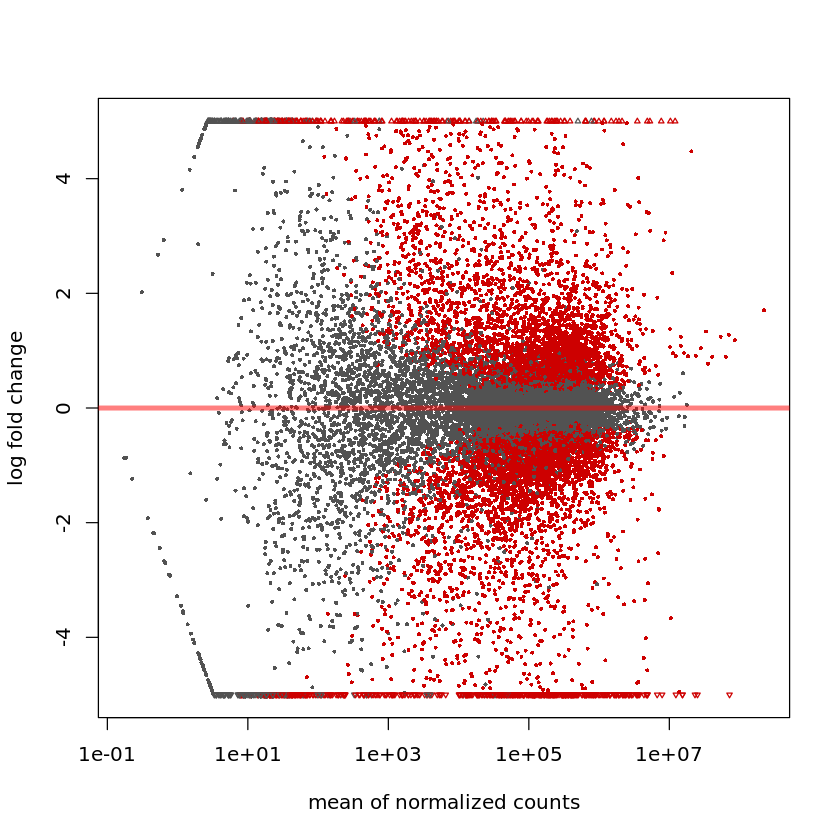

In [25]:
DESeq2::plotMA(object = dds, ylim = c(-5, 5))

Plotting the distribution of p values

Warning message:
"Removed 648 rows containing non-finite values (stat_bin)."


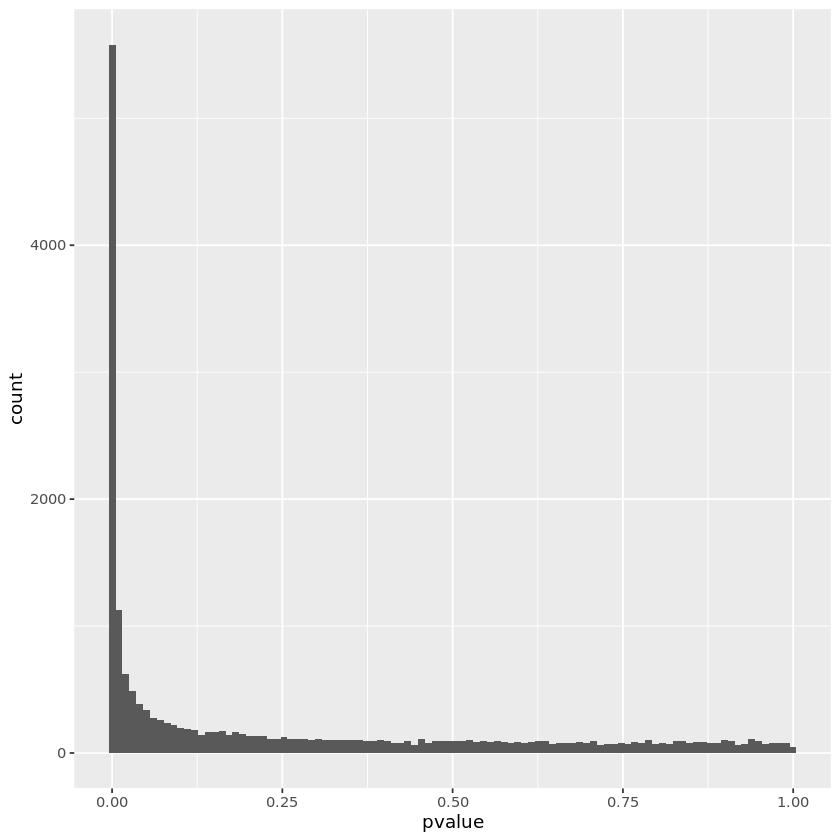

In [26]:
ggplot(data = DEresults, aes(x = pvalue)) + 
  geom_histogram(bins = 100)

<font color='red'>**Q3: If there is no genuine differentially expressed genes, what distribution of p values do you expected to see? Is there any range of the p value matching this expectation?**</font>

#### Check the ajusted p values
By default, p values are are adjusted by [Benjamini-Hochberg method, i.e., FDR](https://en.wikipedia.org/wiki/False_discovery_rate)

Warning message:
"Removed 650 rows containing non-finite values (stat_bin)."


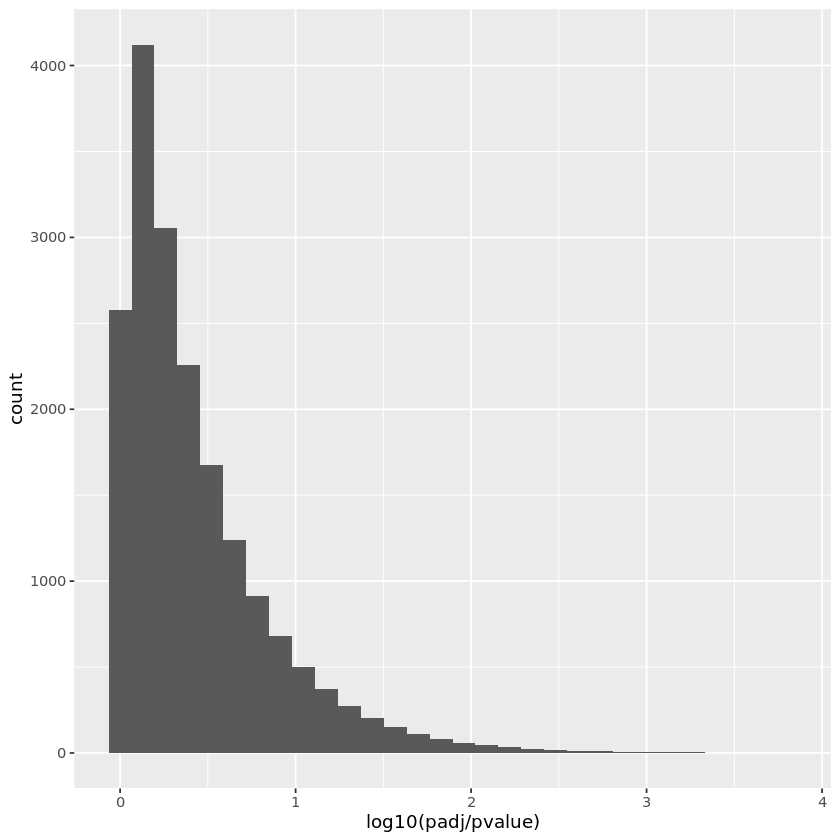

In [27]:
ggplot(data = DEresults, aes(x = log10(padj/pvalue))) + 
  geom_histogram(bins = 30)

### 3.2 Compare to likelihood ratio test
In DESeq2, generalised linear model is used for DE gene detection, and there are two main tests to perform:
1. Wald test (default): estimating the mean and variance of the effect size, and then calculate the p value by Gaussian distribution. Null hypothesis: effect size is zero
2. Likelihood ratio test (taught in lecture): compare the likelihood ratio between two models: with vs without the candidate covariate, and then calculate the p value by Chi-square distribution. Null hypothesis: the likelihood between these two model are the same (or not very different).

In [28]:
dds_LRT <- nbinomLRT(dds, reduced=as.formula('~ 1'))

found results columns, replacing these



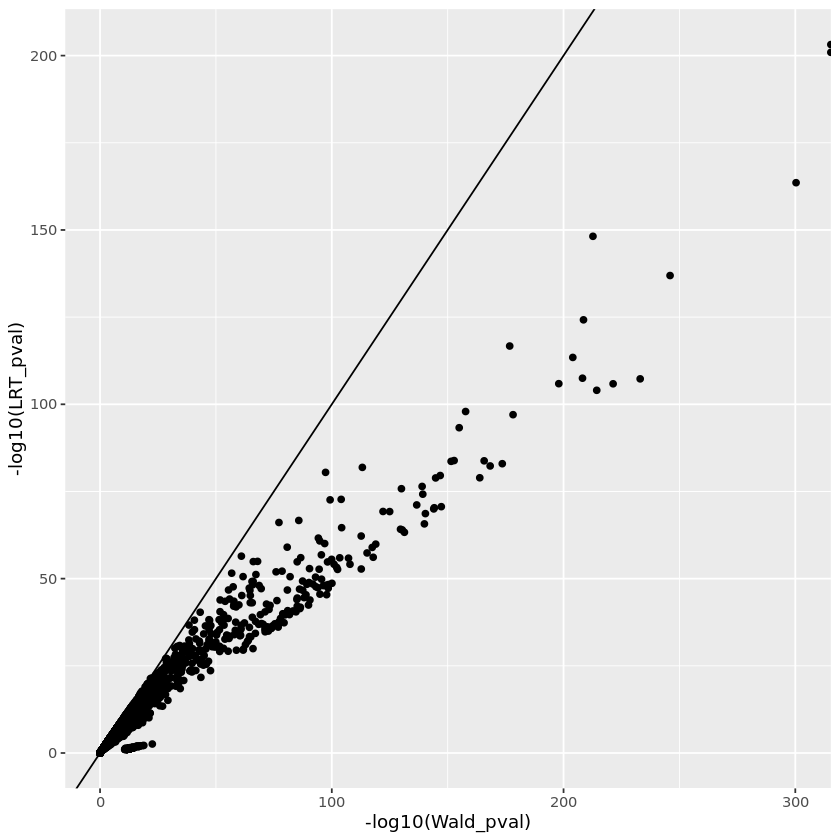

In [29]:
df <- data.frame(Wald_pval = rowData(dds)$WaldPvalue_group_CTRL_vs_CASE,
                 LRT_pval = rowData(dds_LRT)$LRTPvalue)

ggplot(df, aes(x = -log10(Wald_pval), y= -log10(LRT_pval))) + 
  geom_point() + geom_abline(intercept = 0, slope = 1)

<font color='red'>**Q4: What the difference did you see by comparing the p values between these two different tests?**</font>

Hints: consider sensitivity and potential false positives

### 3.3 Multiple factors

The original column data

In [30]:
col_data

,source_name,group
,<fct>,<fct>
CASE_1,metastasized cancer,CASE
CASE_2,metastasized cancer,CASE
CASE_3,metastasized cancer,CASE
CASE_4,metastasized cancer,CASE
CASE_5,metastasized cancer,CASE
CTRL_1,normal colon,CTRL
CTRL_2,normal colon,CTRL
CTRL_3,normal colon,CTRL
CTRL_4,normal colon,CTRL


#### Additional factor
As an illustration, we introduce an madeup factor. We assume that the CASE_1, CASE_2 and CTRL_1, CTRL_2 are one setting, e.g., (paired-end), and the other based on another setting, e.g., (single-end). 

Now we want to consider the variations that comes from this additional factor, and how it affects the differential expression between normal and cancer

In [31]:
col_data_2f <- col_data
col_data_2f$type <- c(1, 1, 0, 0, 0, 1, 1, 0, 0, 0)
col_data_2f

,source_name,group,type
,<fct>,<fct>,<dbl>
CASE_1,metastasized cancer,CASE,1
CASE_2,metastasized cancer,CASE,1
CASE_3,metastasized cancer,CASE,0
CASE_4,metastasized cancer,CASE,0
CASE_5,metastasized cancer,CASE,0
CTRL_1,normal colon,CTRL,1
CTRL_2,normal colon,CTRL,1
CTRL_3,normal colon,CTRL,0
CTRL_4,normal colon,CTRL,0


In [32]:
#define the design formula
designFormula <- "~ group + type"

#create a DESeq dataset object from the count matrix and the colData 
ddsTwoFactor <- DESeqDataSetFromMatrix(countData = counts[, 1:10], 
                                       colData = col_data_2f, 
                                       design = as.formula(designFormula))
                              
# Remove unexpressed genes
ddsTwoFactor <- ddsTwoFactor[ rowSums(ddsTwoFactor@assays@data$counts) > 1, ]

#print dds object to see the contents
print(ddsTwoFactor)

converting counts to integer mode

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



class: DESeqDataSet 
dim: 19097 10 
metadata(1): version
assays(1): counts
rownames(19097): TSPAN6 TNMD ... MYOCOS HSFX3
rowData names(0):
colnames(10): CASE_1 CASE_2 ... CTRL_4 CTRL_5
colData names(3): source_name group type


In [33]:
ddsTwoFactor <- DESeq(ddsTwoFactor)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [34]:
ddsTwoFactor_LRT <- nbinomLRT(ddsTwoFactor, reduced=as.formula('~ type'))

found results columns, replacing these



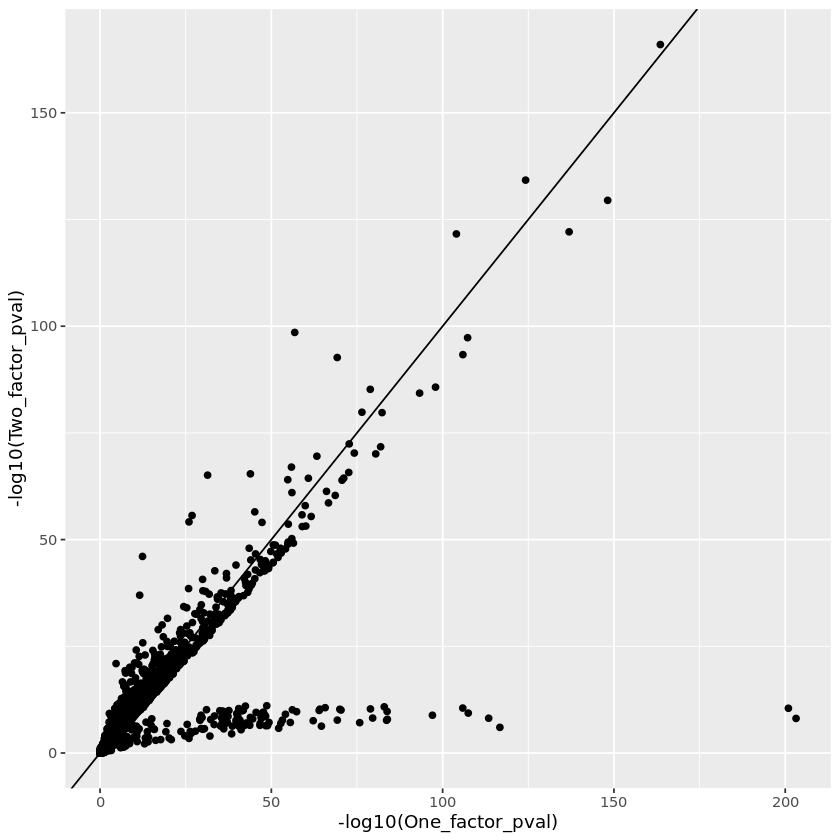

In [35]:
df <- data.frame(One_factor_pval = rowData(dds_LRT)$LRTPvalue,
                 Two_factor_pval = rowData(ddsTwoFactor_LRT)$LRTPvalue)

ggplot(df, aes(x = -log10(One_factor_pval), y= -log10(Two_factor_pval))) + 
  geom_point() + geom_abline(intercept = 0, slope = 1)

<font color='red'>**Q5: What is the difference between p values when considering additional variable? What is the possible reason?**</font>

Hints: consider the source of the variations

## 4. Gene set analysis (this section is optional)

### Get DE genes

In [36]:
#compute the contrast for the 'group' variable where 'CTRL' 
#samples are used as the control group. 

DE_res = results(dds_LRT, contrast = c("group", 'CASE', 'CTRL'))

#sort results by increasing p-value
DE_res <- as.data.frame(DE_res[order(DE_res$pvalue), ])

In [37]:
#remove genes with NA values 
DE_genes <- DE_res[!is.na(DE_res$padj), ]

#select genes with adjusted p-values below 0.1
DE_genes <- DE_genes[DE_genes$padj < 0.05, ]

#select genes with absolute log2 fold change above 1 (two-fold change)
DE_genes <- DE_genes[abs(DE_genes$log2FoldChange) > 1, ]

In [38]:
head(DE_genes)
dim(DE_genes)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGBP,10349993.2,-7.575787,0.1864329,928.3288,6.816856e-204,1.257642e-199
CYP2E1,4829888.9,9.360244,0.2152217,918.0329,1.179584e-201,1.088107e-197
ASGR2,426421.7,8.018301,0.2162068,746.1100,2.813373e-164,1.730131e-160
PRG4,166224.9,5.283507,0.1694583,675.4034,6.676386e-149,3.079316e-145
GCKR,100182.7,7.828413,0.2333762,623.6666,1.192012e-137,4.398286e-134
ZG16,2122231.5,-6.974906,0.2258976,565.2704,5.999916e-125,1.844874e-121


[1] 3885    6

### GO enrichment analysis

In a typical differential expression analysis, thousands of genes are found differentially expressed between two groups of samples. Besides exploring individual gens, we can also calculate the overlap between DE genes and annotated gene sets for function assocation, e.g., Gene Ontology (GO) terms.

You could copy the above 3885 DE genes into the web server, e.g., [GO website](http://geneontology.org) or [David web server](https://david.ncifcrf.gov/).

Here, we show how to use R package `gProfileR` to perform this overlap enrichment analyis.

In [39]:
# Only need install once

install.packages('gProfileR')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [40]:
library(gProfileR)

In [41]:
#get the list of genes of interest
genesOfInterest <- rownames(DE_genes)

#calculate enriched GO terms
goResults <- gprofiler(query = genesOfInterest, 
                     organism = 'hsapiens', 
                     src_filter = 'GO', 
                     hier_filtering = 'moderate')

Warning message:
"Please consider using the new package "gprofiler2". At the moment you are using a deprecated package relying on outdated data.
  More information at https://biit.cs.ut.ee/gprofiler/page/r-new. Feel free to contact us at biit.support@ut.ee for further help."


In [42]:
col_show <- c('p.value', 'term.size', 'query.size', 'overlap.size', 'term.name')
head(goResults[order(goResults$p.value), col_show], 10)

,p.value,term.size,query.size,overlap.size,term.name
,<dbl>,<int>,<int>,<int>,<chr>
40,5.54e-57,2740,3755,858,plasma membrane part
10,2.61e-35,3656,3755,993,regulation of biological quality
4,3.33e-28,1073,3755,364,organic acid metabolic process
28,2.06e-25,385,3755,169,extracellular structure organization
64,3.86e-19,1251,3755,380,transporter activity
29,4.96e-19,1399,3755,415,lipid metabolic process
49,1.67e-17,371,3755,149,apical part of cell
8,4.14e-16,3447,3755,858,regulation of cell communication
42,4.88e-16,3788,3755,930,vesicle
